In [1]:
%%bash
nrnivmodl

/home/alex/Dropbox/Williams-etal-Synaptic-Transport/results/05
h.mod kadist.mod kaprox.mod kdrca1.mod km.mod na3n.mod naxn.mod vecevent.mod
h.mod kadist.mod kaprox.mod kdrca1.mod km.mod na3n.mod naxn.mod vecevent.mod
"/home/alex/neuron/nrn-7.4/share/nrn/libtool"  --mode=compile gcc -DHAVE_CONFIG_H  -I. -I.. -I"/home/alex/neuron/nrn-7.4/include/nrn" -I"/home/alex/neuron/nrn-7.4/x86_64/lib"      -g -O2 -c -o mod_func.lo mod_func.c
libtool: compile:  gcc -DHAVE_CONFIG_H -I. -I.. -I/home/alex/neuron/nrn-7.4/include/nrn -I/home/alex/neuron/nrn-7.4/x86_64/lib -g -O2 -c mod_func.c  -fPIC -DPIC -o .libs/mod_func.o
"/home/alex/neuron/nrn-7.4/share/nrn/libtool"  --mode=link gcc -module  -g -O2    -o libnrnmech.la -rpath "/home/alex/neuron/nrn-7.4/x86_64/lib"  h.lo kadist.lo kaprox.lo kdrca1.lo km.lo na3n.lo naxn.lo vecevent.lo mod_func.lo  -L"/home/alex/neuron/nrn-7.4/x86_64/lib" -lnrnoc -loc -lmemacs -lnrnmpi -lscopmath -lsparse13 -lreadline -lncurses -L"/home/alex/neuron/nrn-7.4/x86_64/lib" "/

In [2]:
# Download NEURON: http://www.neuron.yale.edu/neuron/download
# Download PyNeuronToolbox: https://github.com/ahwillia/PyNeuron-Toolbox

from neuron import h
import numpy as np
import pylab as plt
import scipy.linalg
from PyNeuronToolbox.record import ez_record,ez_convert
from PyNeuronToolbox.morphology import shapeplot,shapeplot_animate
from mpl_toolkits.mplot3d import Axes3D
from JSAnimation import IPython_display
from matplotlib import animation
from matplotlib.pyplot import cm
%matplotlib inline
np.random.seed(123456789)

# Load morphology and other stuff
# --> SegLists: soma[2], dend[74], dend_5[37], apic[42], axon[1]
# --> Files from Migliore & Migliore (2012)
# --> CA1 pyramidal neuron
h.load_file('stdrun.hoc')
h.xopen('ri06.hoc')
h.xopen('fixnseg.hoc')
h.xopen('5a_nogui.hoc')
h.tstop = 700.0

In [3]:
from PyNeuronToolbox.morphology import dist_between,allsec_preorder

def dist_to_soma(segment):
    return dist_between(h,h.soma[0](0.5),segment)

#seglist in pre-order
sec_list = allsec_preorder(h)
seg_list = []
for sec in sec_list:
    locs = np.linspace(0,1,sec.nseg+2)[1:-1]
    for loc in locs:
        seg_list.append(sec(loc))
n = len(seg_list)

In [4]:
def sushi_system(a,b,c,d):
    """
    Returns a matrix A, such that dx/dt = A*x
    
    N = # of compartments
    A is (2N x 2N) matrix
    x is (2N x 1) vector.
      The first N elements correspond to concentrations of u (molecules in transit)
      The second half correspond to concentrations of u-star (active molecules)
    The trafficking rate constants along the microtubules are given by the vectors "a" and "b"
    The rate constants for u turning into u* is given by the vector "c"
    The rate constants for the degradation of u* is given by the vector "d"
    """
    # number of compartments
    N = len(d)
    
    ## State-space equations
    #  dx/dt = Ax + Bu
    A = np.zeros((2*N,2*N))

    # Trafficking along belt
    # Iterative traversal of dendritic tree in pre-order
    i = 0
    section = None
    parentStack = [(None,h.soma[0])]
    while len(parentStack)>0:
        # Get next section to traverse
        #  --> p is parent index, section is h.Section object
        (p,section) = parentStack.pop()
        
        # Trafficking to/from parent
        if p is not None:
            # Out of parent, into child
            ai = a.pop()
            A[p,p] += -ai
            A[i,p] += ai
            # Into parent, out of child
            bi = b.pop()
            A[p,i] += bi
            A[i,i] += -bi
        
        # visit all segments in compartment
        for (j,seg) in enumerate(section):
            # Deal with out/into rates within compartment, just tridiag matrix
            if j>0:
                # Out of parent, into child
                ai = a.pop()
                A[i-1,i-1] += -ai
                A[i,i-1] += ai
                # Into parent, out of child
                bi = b.pop()
                A[i-1,i] += bi
                A[i,i] += -bi
            # move onto next compartment
            i += 1
        
        # now visit children in pre-order
        child_list = list(h.SectionRef(sec=section).child)
        if child_list is not None:
            child_list.reverse()
        for c_sec in child_list:
            parentStack.append([i-1,c_sec]) # append parent index and child
    
    # Trafficking off the belt
    for i in range(N):
        A[i,i] += -c[i]
        A[i+N,i] += c[i]

    # Degradation after being taken off the belt
    for i in range(N):
        A[i+N,i+N] = -d[i]
    
    return A

In [5]:
def trafficking_solution(utarg):
    """ Solve the problem by tuning trafficking rates, like Figs 1 and 2. """
    x = []
    
    # Iterative traversal of dendritic tree in pre-order
    i = 0
    section = None
    parentStack = [(None,h.soma[0])]
    while len(parentStack)>0:
        # Get next section to traverse
        #  --> p is parent index, section is h.Section object
        (p,section) = parentStack.pop()
        
        # Trafficking to/from parent
        if p is not None:
            mp = utarg[p] # concentration in parent
            mc = utarg[i] # concentration in child
            x.insert(0,mp/mc)
        
        # visit all segments in compartment
        for (j,seg) in enumerate(section):
            # Deal with out/into rates within compartment, just tridiag matrix
            if j>0:
                mp = utarg[i-1]
                mc = utarg[i]
                x.insert(0,mp/mc)
                
            # move onto next compartment
            i += 1
        
        # now visit children in pre-order
        child_list = list(h.SectionRef(sec=section).child)
        if child_list is not None:
            child_list.reverse()
        for c_sec in child_list:
            parentStack.append([i-1,c_sec]) # append parent index and child
    
    # return calculated guesses (flip, up/down since get_deriv pops from start)
    return np.array(x)

def get_sys_matrix(utarg,F=0.5,Ctau=1e-3):
    # F is a mixing factor between 0 and 1
    K = np.sum(utarg)/n
    x = trafficking_solution(F*utarg + (1-F)*K)
    a = (1/(1+x))
    a = list(a)
    b = list((1/(1+x**-1)))
    d = list(np.zeros(n))#list(np.ones(n)*1e-7)
    c = list(Ctau*utarg/(F*utarg + (1-F)*K))
    A = sushi_system(a,b,c,d)
    return A

In [6]:
# matrix exponential used to solve linear system
from scipy.linalg import expm

# initial condition, u starts only in soma and is trafficked out to dendrites
u0 = np.zeros(2*n)
u0[0] = 1.0  # compartment 0 is the soma

In [7]:
def solve_u(w,V,Vinv,t):
    D = np.diag(np.exp(w*t))          # diagonal matrix exponential
    PHI = np.real(V.dot(D.dot(Vinv))) # state transition matrix
    return PHI.dot(u0)                # calculate u(t)

def run_sim(A,nframes=10):
    # Run a simulation (log time)
    # --> this is a linear system; thus, matrix exponential provides exact solution
    utrace = [u0]
    t = np.logspace(-0.5,8.5,nframes)
    w,V = scipy.linalg.eig(A)
    Vinv = np.linalg.inv(V)
    t = np.logspace(-0.5,8.5,nframes)
    for t_ in t: utrace.append(solve_u(w,V,Vinv,t_))
    return np.array(utrace).T

def animate_sim(climits=[0,0.0035]):
    u = utrace[n:,:]
    fig = plt.figure(figsize=(8,8))
    shapeax = plt.subplot(111, projection='3d')
    lines = shapeplot(h,shapeax,order='pre',lw=2)
    shapeax.view_init(elev=80,azim=-90)
    plt.title('distribution of active/detached cargo',fontweight='bold',fontsize=14)
    plt.axis('off')

    # Hack to get a colorbar
    # http://stackoverflow.com/questions/8342549/matplotlib-add-colorbar-to-a-sequence-of-line-plots
    sm = plt.cm.ScalarMappable(cmap=plt.cm.cool, norm=plt.Normalize(climits[0],climits[1])) 
    sm._A = []
    plt.colorbar(sm, shrink=0.5)
    plt.tight_layout()

    anim_func = shapeplot_animate(u.T,lines,u.shape[1],clim=climits,cmap=cm.cool)
    return animation.FuncAnimation(fig, anim_func, frames=u.shape[1], interval=5e2, blit=True)

def snap_ss(name,clim=[0,0.0035]):
    u = utrace[n:,:]
    fig = plt.figure(figsize=(8,8))
    shapeax = plt.subplot(111, projection='3d')
    lines = shapeplot(h,shapeax,cvals=u[:,-1],clim=clim,\
                      cmap=plt.cm.cool,order='pre',lw=2)
    shapeax.view_init(elev=80,azim=-90)
    plt.title('steady-state',fontweight='bold',fontsize=14)

    # colorbar
    sm = plt.cm.ScalarMappable(cmap=plt.cm.cool, norm=plt.Normalize(clim[0],clim[1])) 
    sm._A = []
    plt.colorbar(sm, shrink=0.5)
    plt.tight_layout()
    plt.axis('off')
    #plt.savefig(name+'.svg')

First Case: timescales separated ($c_i$ small), little interference/competition
-----


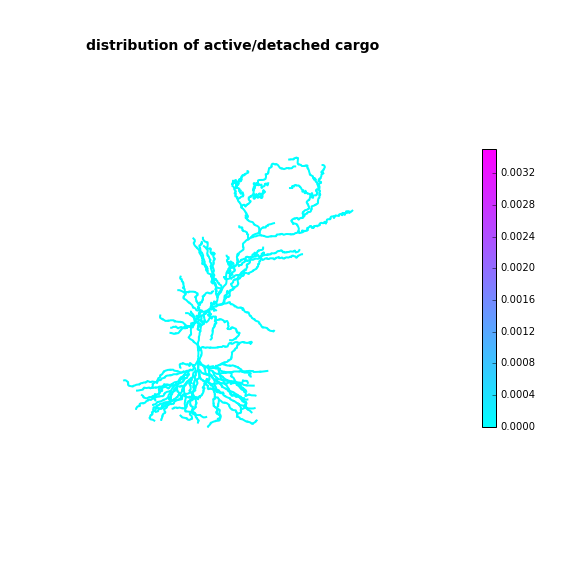
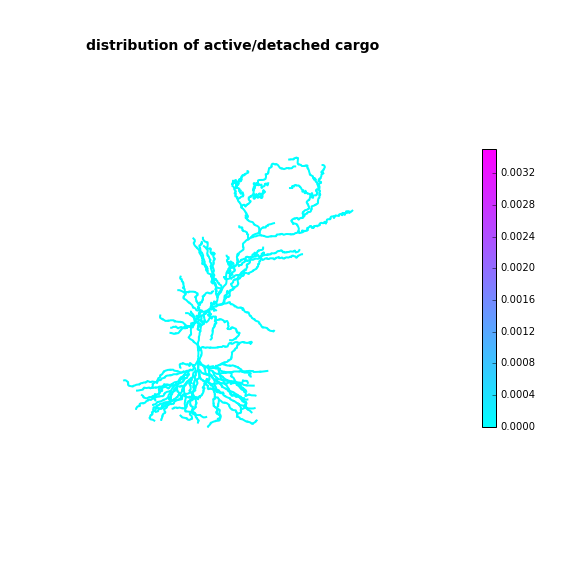
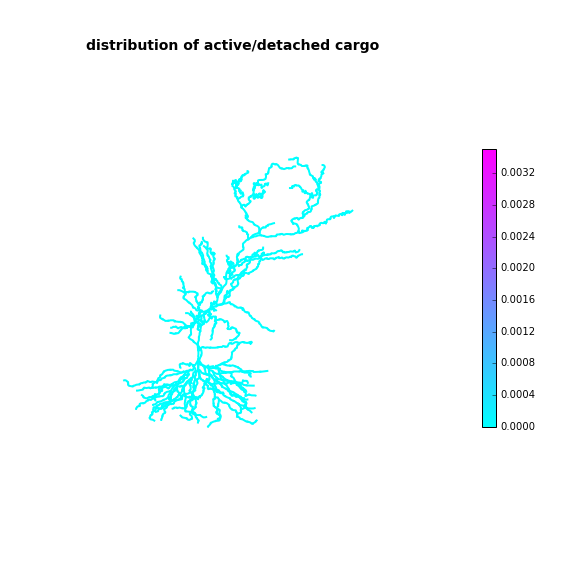
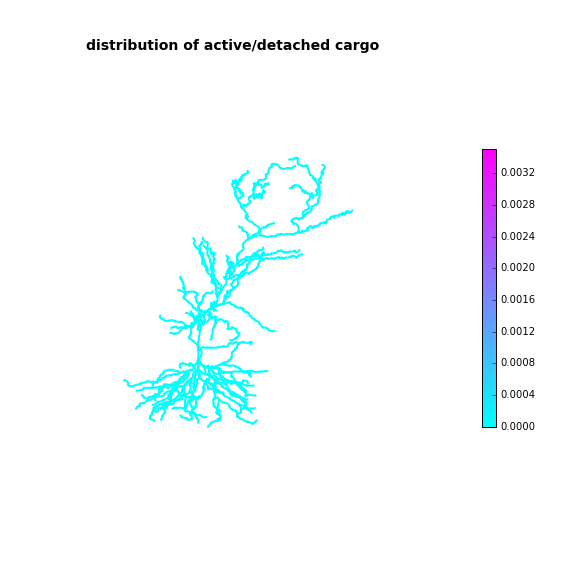
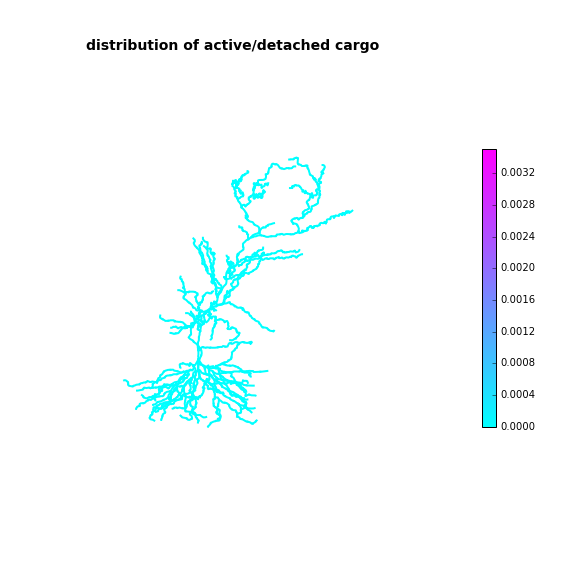
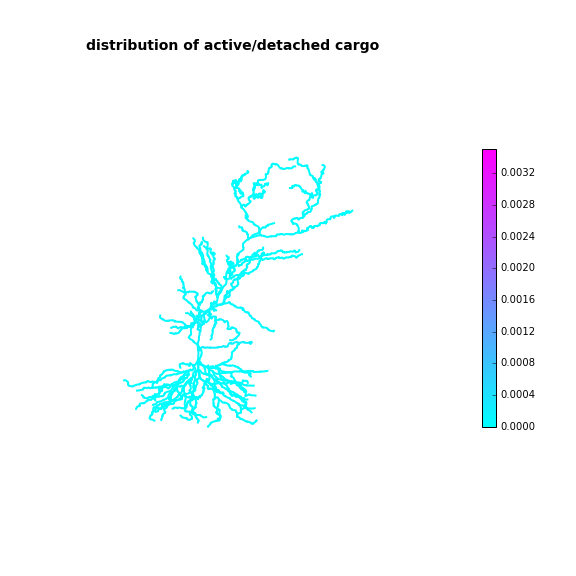
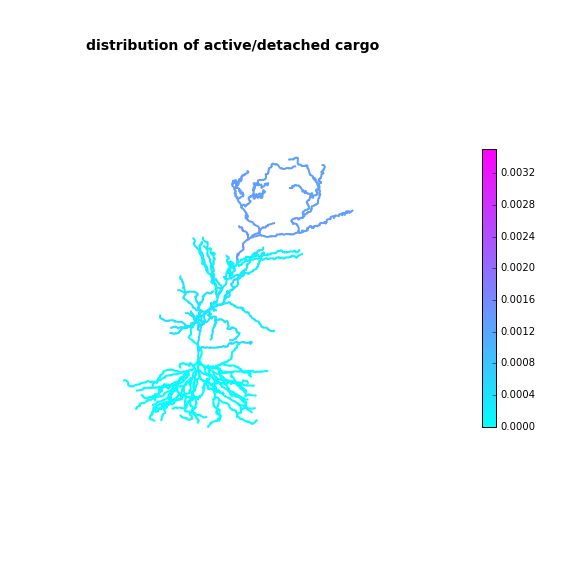
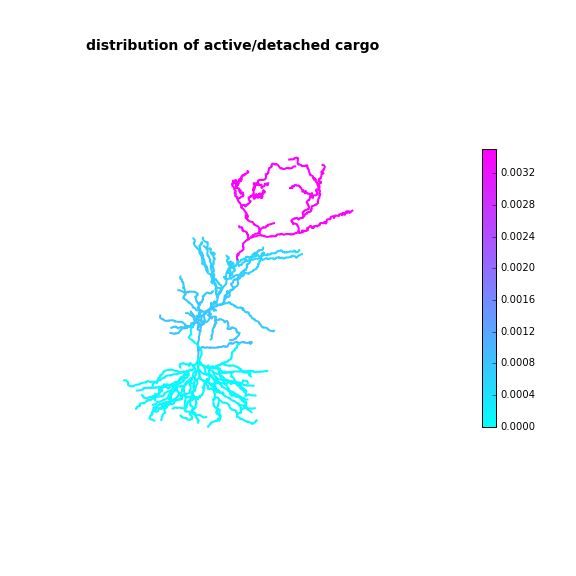
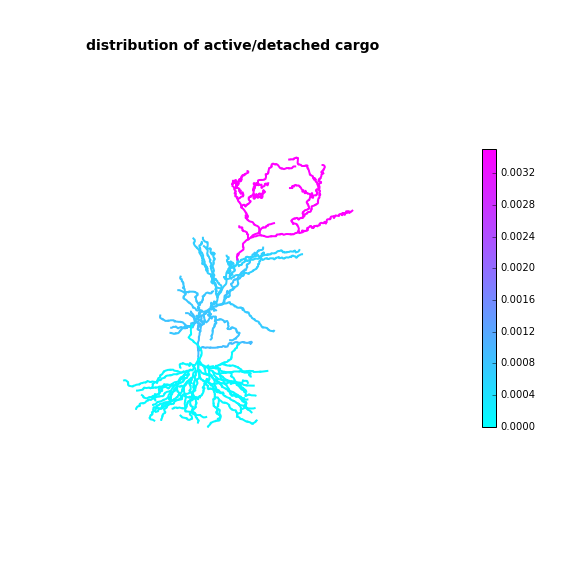
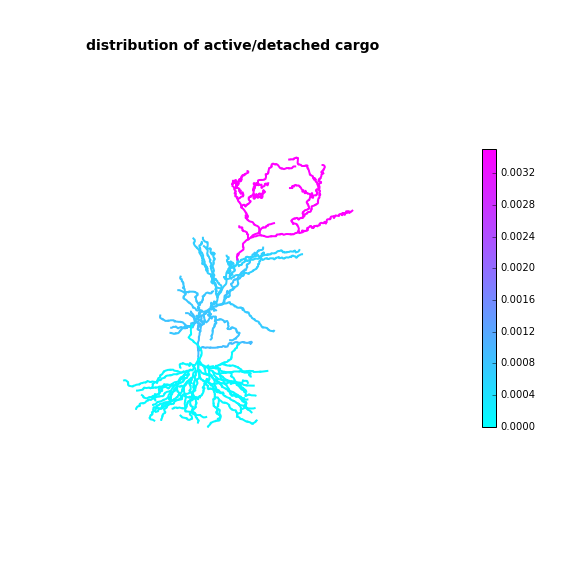
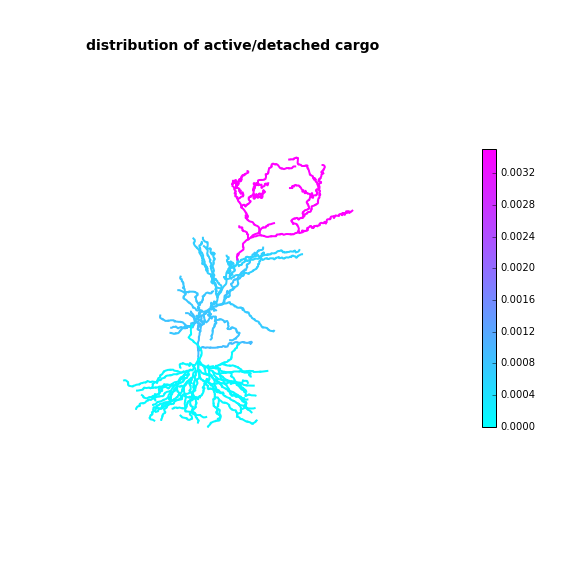

In [8]:
# Distal inputs alone
utarg = np.ones(len(seg_list))
utarg[260:393] *= 10
utarg[393:] *= 0.1 # no trafficking to basal dend
utarg /= np.sum(utarg)

# Run simulation
A = get_sys_matrix(utarg,F=1,Ctau=1e-5)
utrace = run_sim(A)

# animation
animate_sim()


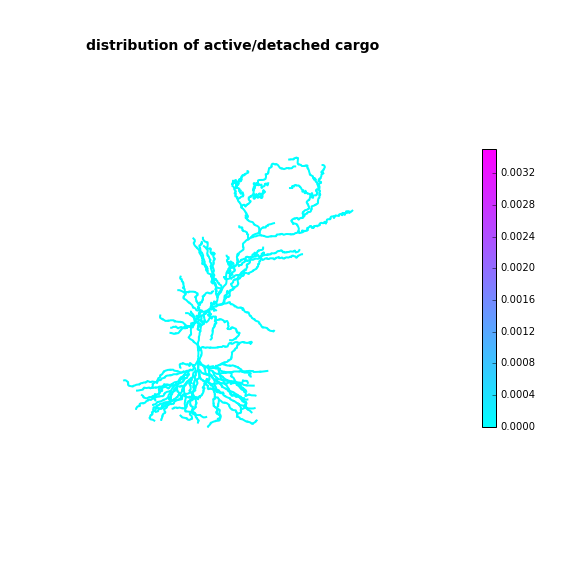
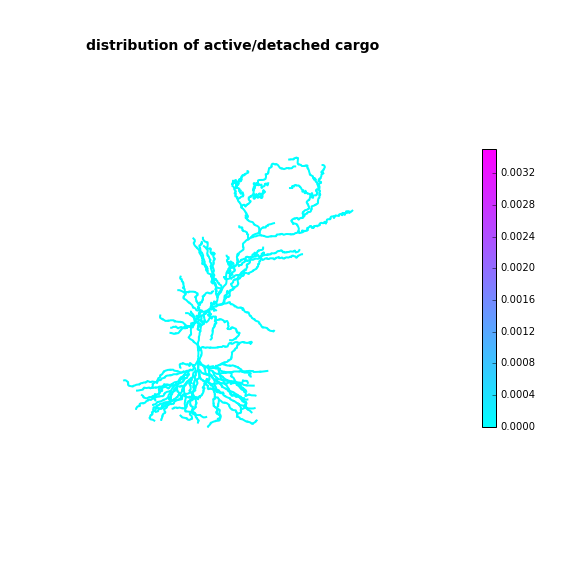
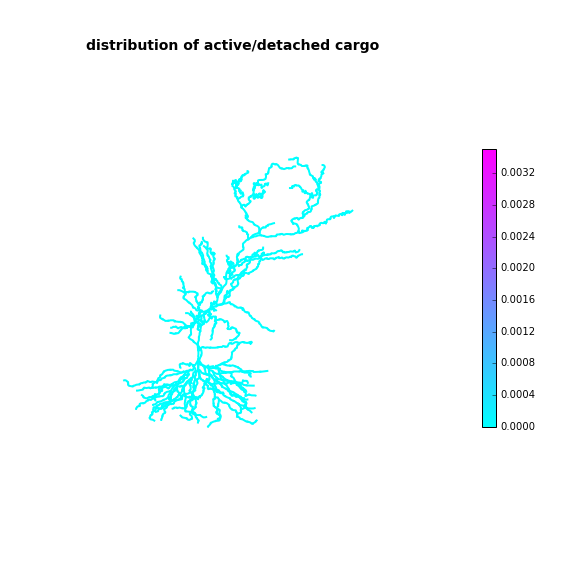
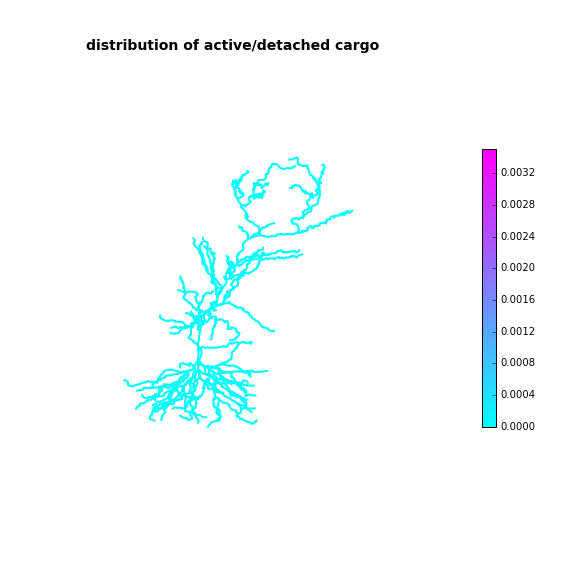
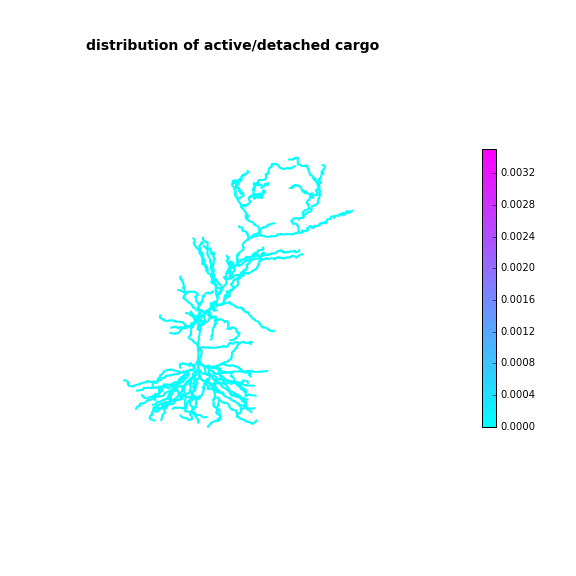
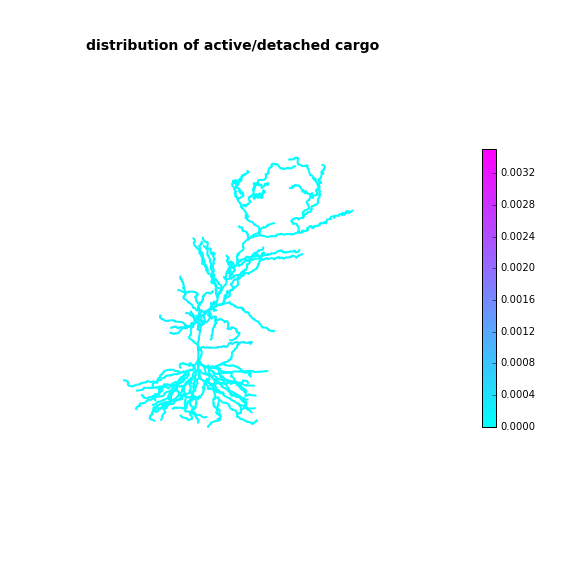
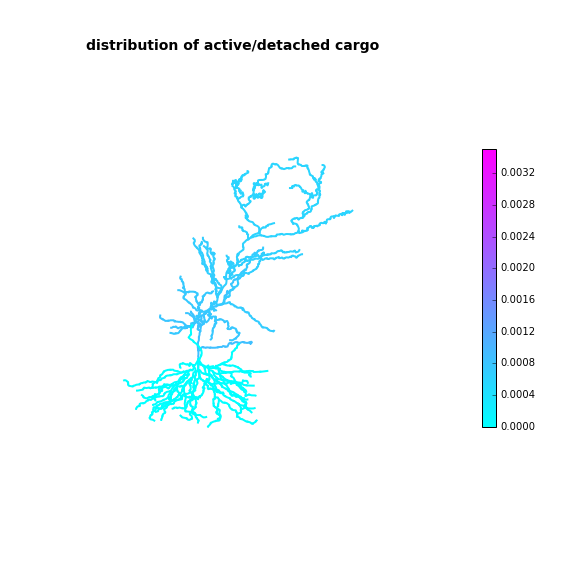
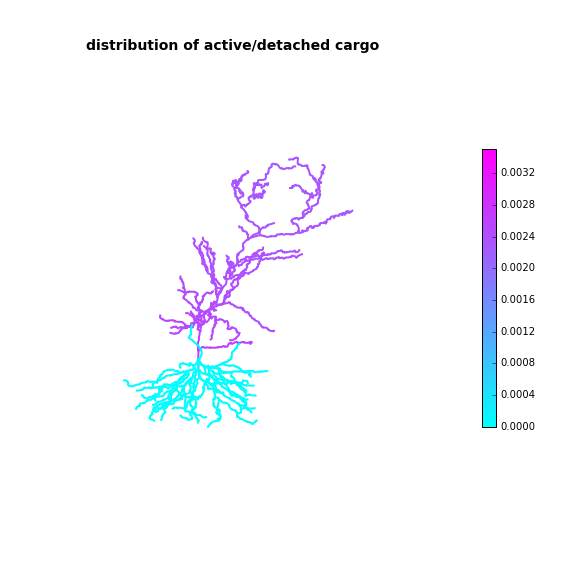
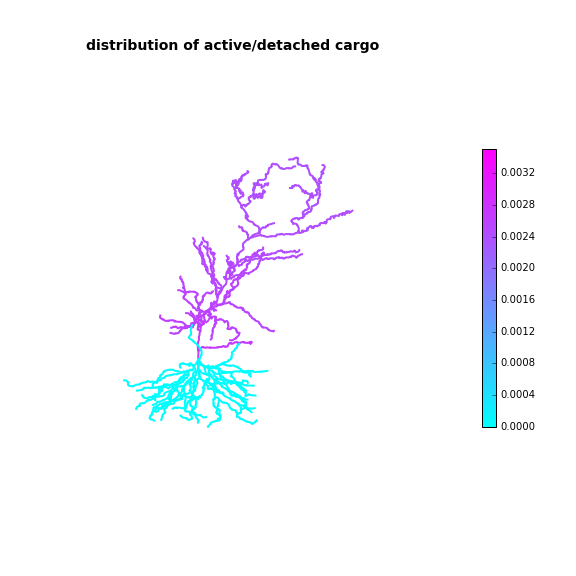
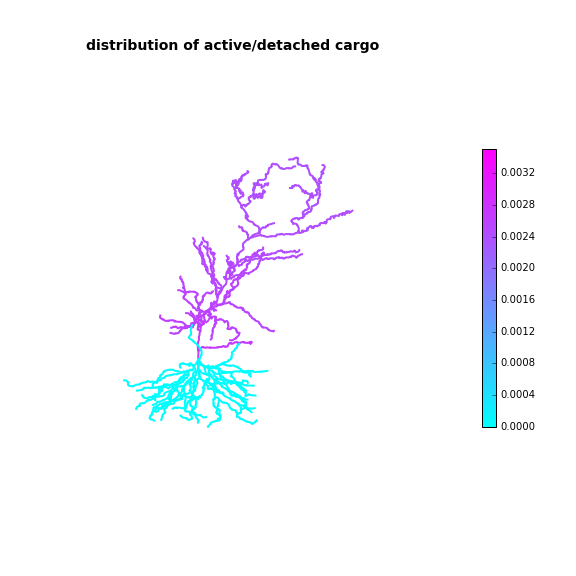
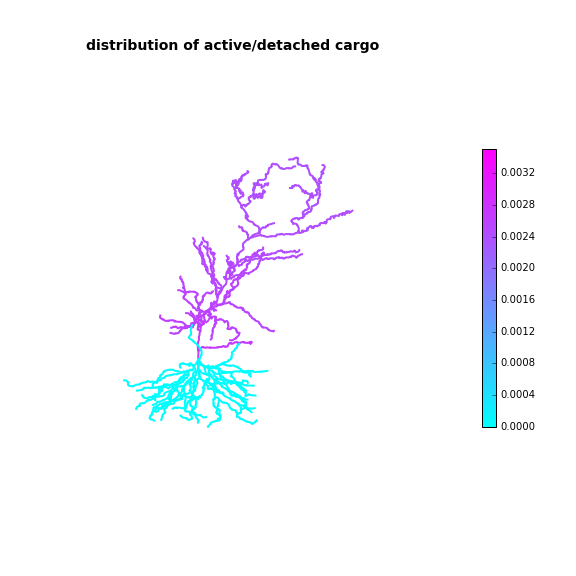

In [9]:
# Distal and Proximal together
utarg = np.ones(len(seg_list))
utarg[:393] *= 10
utarg[393:] *= 0.1 # no trafficking to basal dend
utarg /= np.sum(utarg)

# Run simulation
A = get_sys_matrix(utarg,F=1,Ctau=1e-5)
utrace = run_sim(A)

# snapshot of steady-state
# snap_ss('1b')

# animation
animate_sim()

Second Case: timescales not separated, proximal inputs are *greedy* and prevent distal transport
----


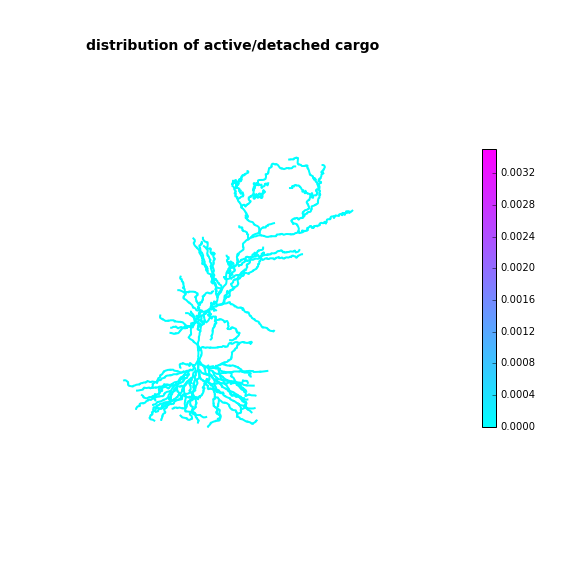
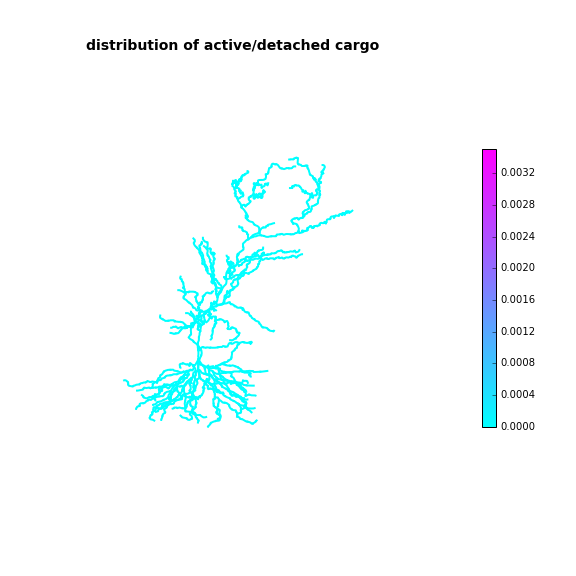
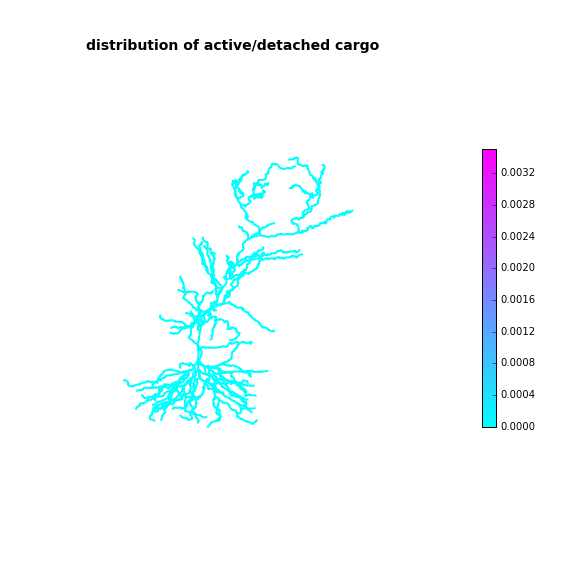
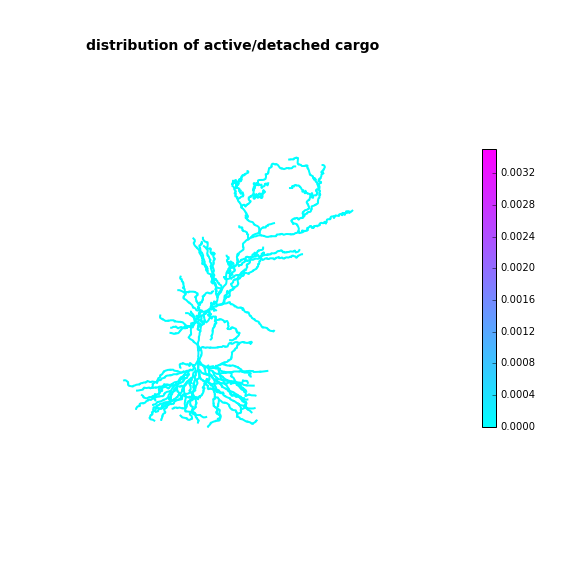
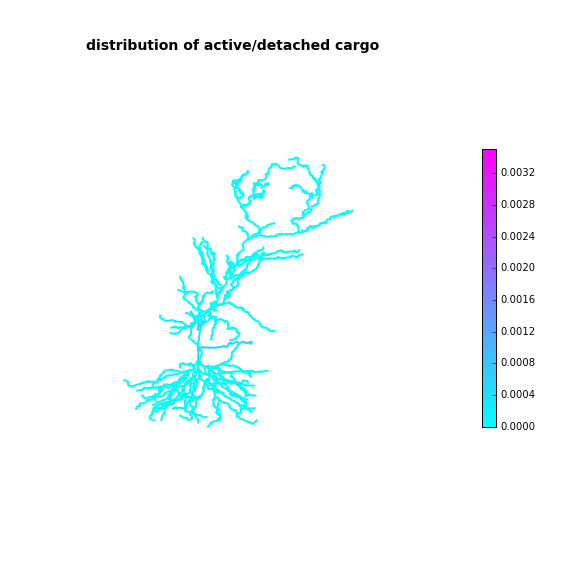
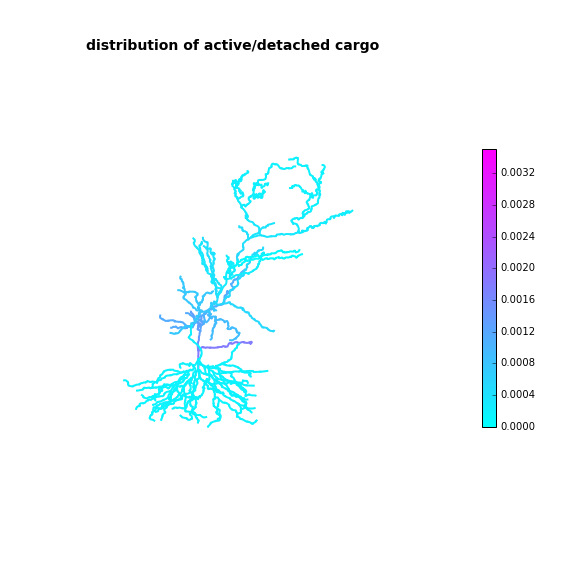
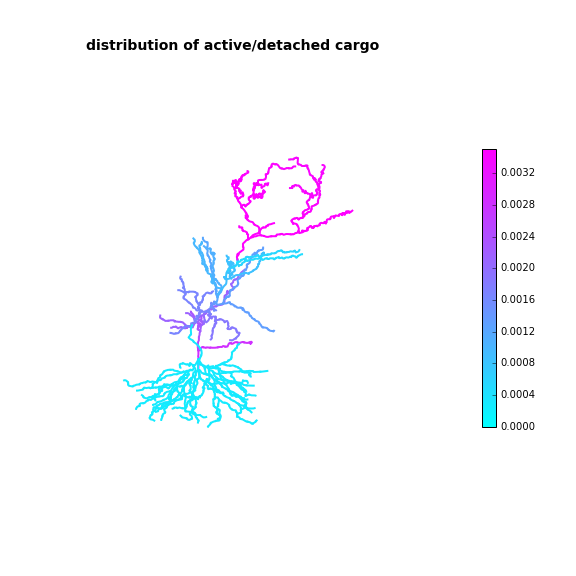
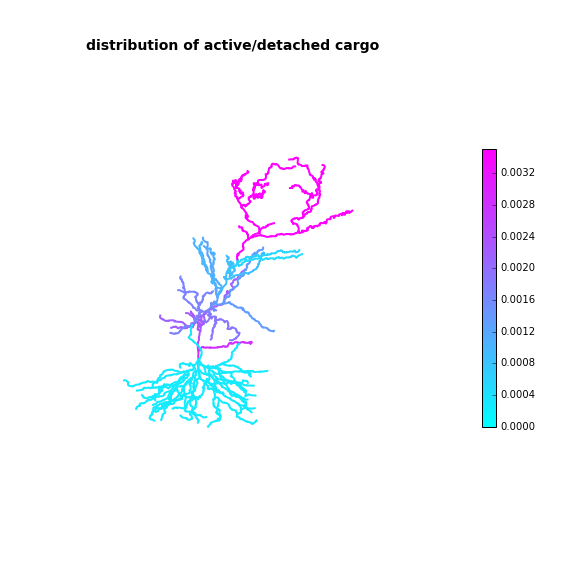
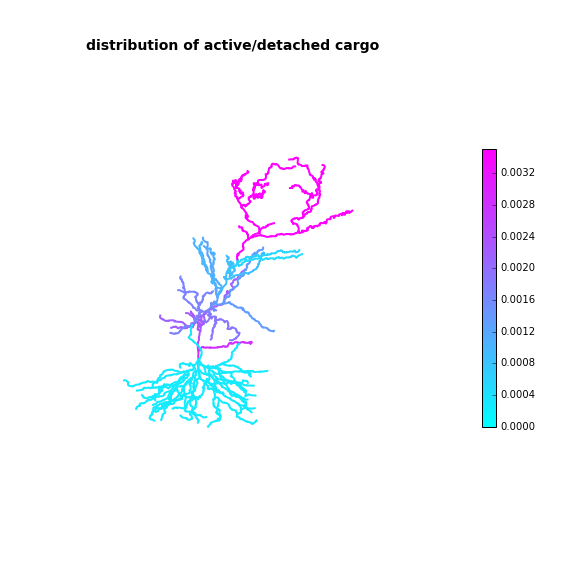
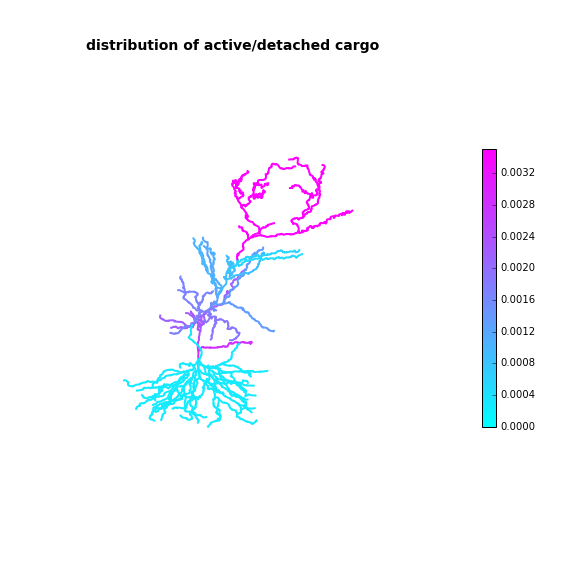
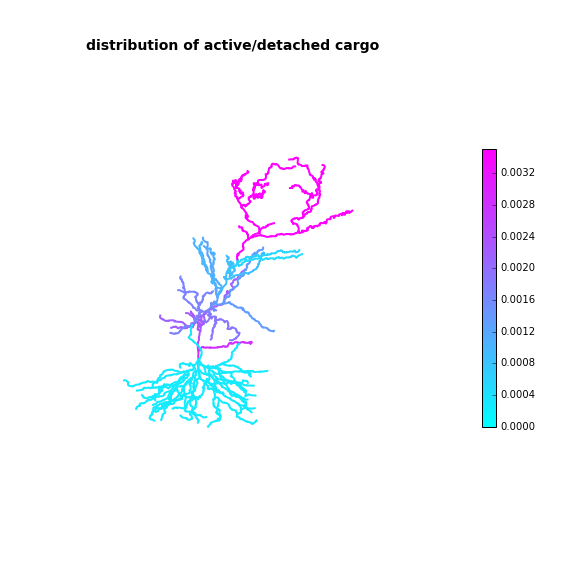

In [10]:
# Distal inputs alone
utarg = np.ones(len(seg_list))
utarg[260:393] *= 10
utarg[393:] *= 0.1 # no proximal trafficking
utarg /= np.sum(utarg)

# Run simulation
A = get_sys_matrix(utarg,F=1,Ctau=1e-4)
utrace = run_sim(A)

# snapshot of steady-state
# snap_ss('2a')

# animation
animate_sim()


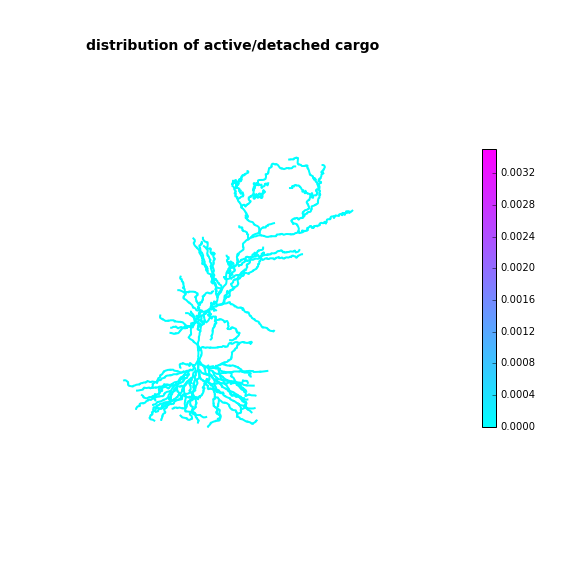
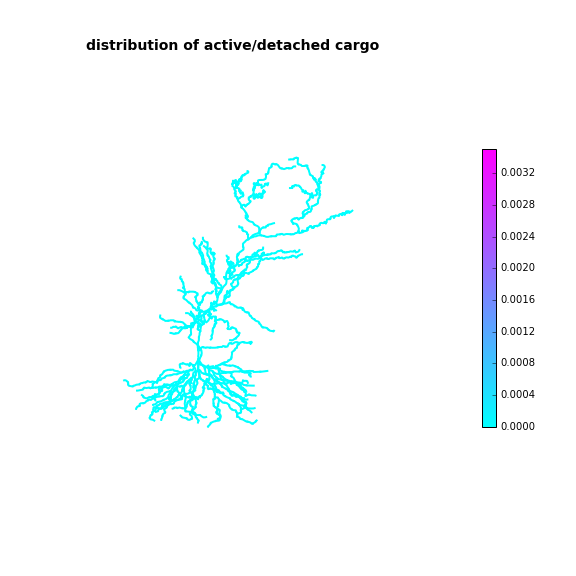
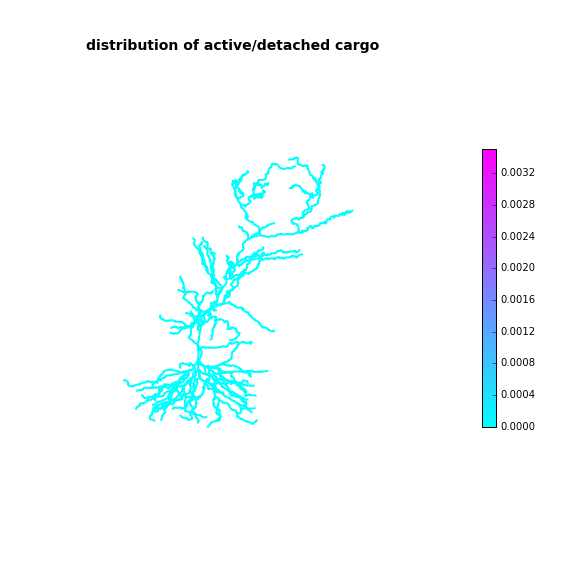
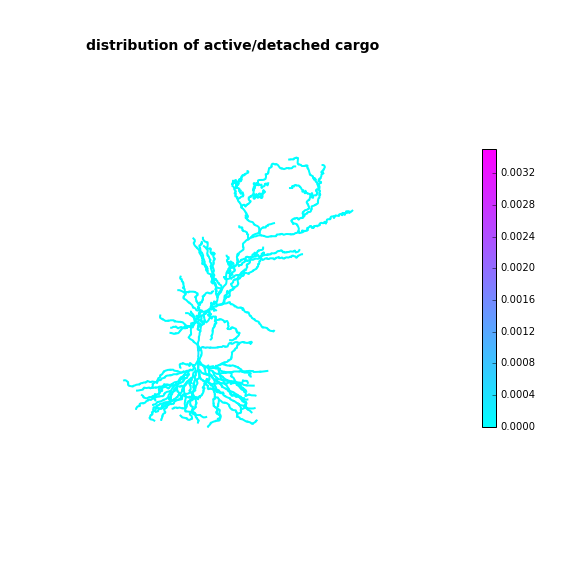
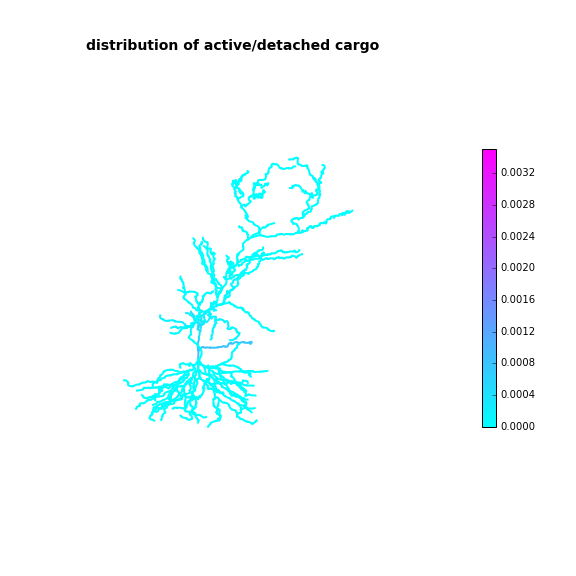
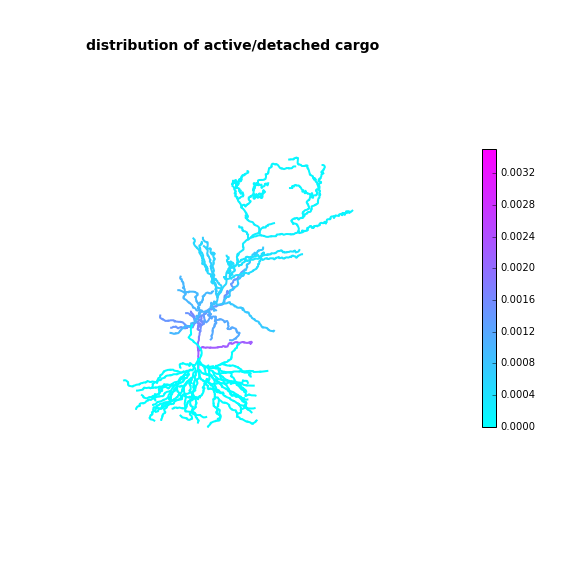
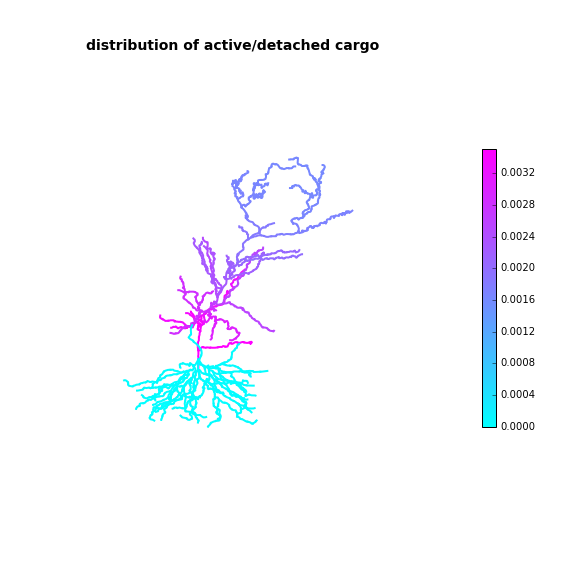
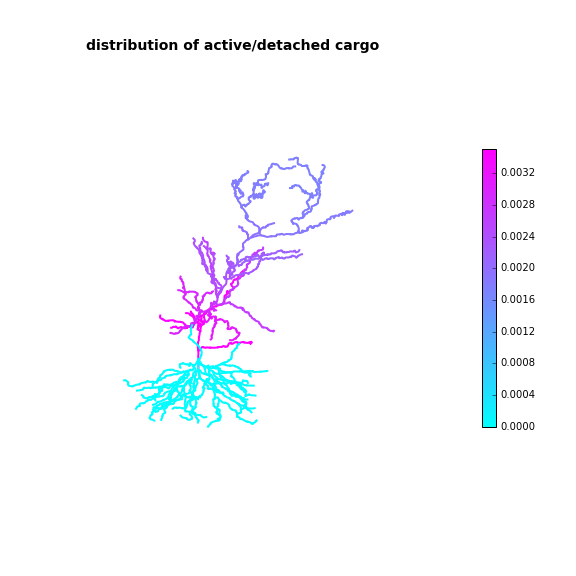
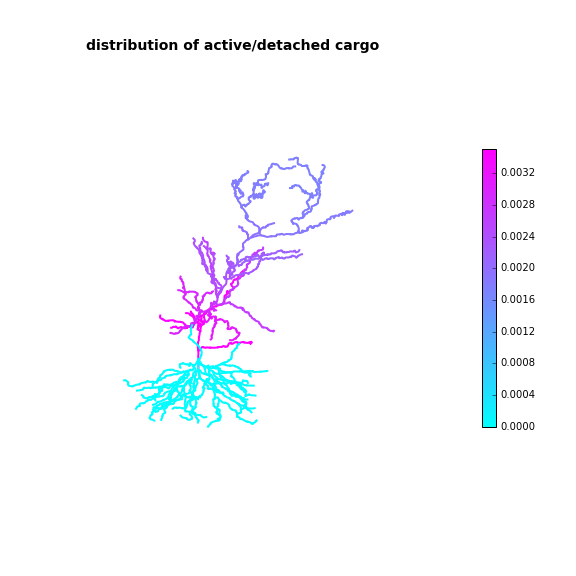
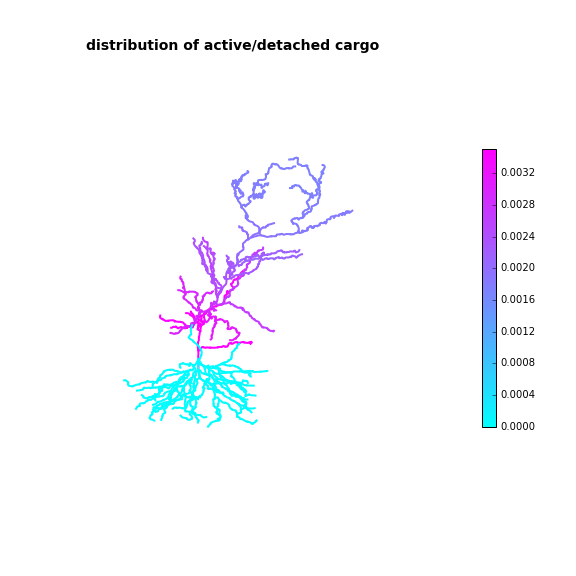
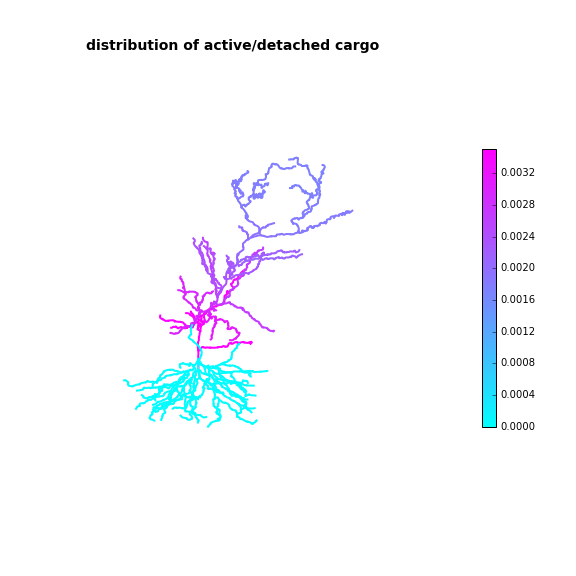

In [11]:
# Distal and Proximal together
utarg = np.ones(len(seg_list))
utarg[:393] *= 10
utarg[393:] *= 0.1 # no proximal trafficking
utarg /= np.sum(utarg)

# Run simulation
A = get_sys_matrix(utarg,F=1,Ctau=1e-4)
utrace = run_sim(A)

# snapshot of steady-state
# snap_ss('2b')

# animation
animate_sim()

Third Case: Time scales separated, different trafficking strategy
------


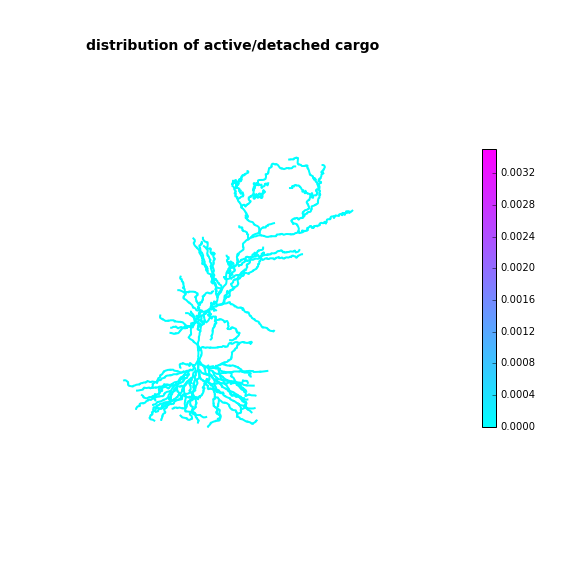
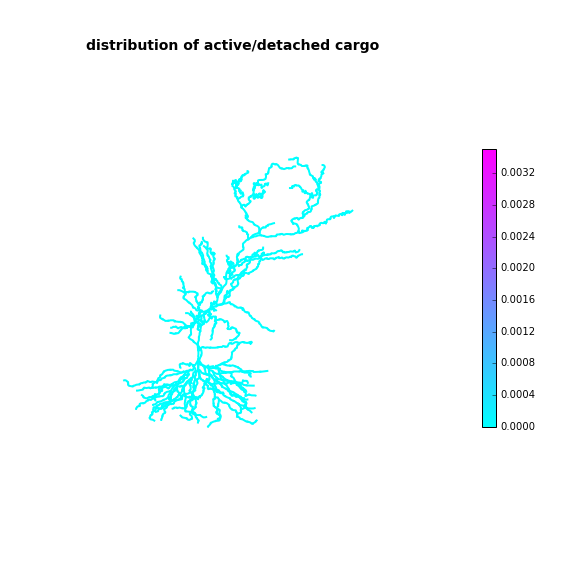
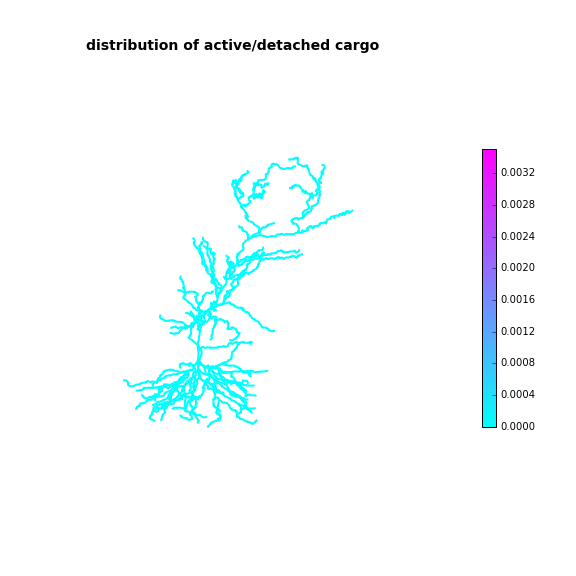
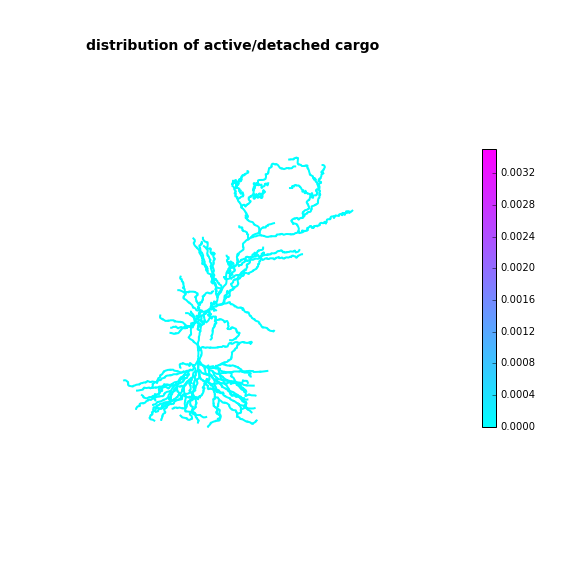
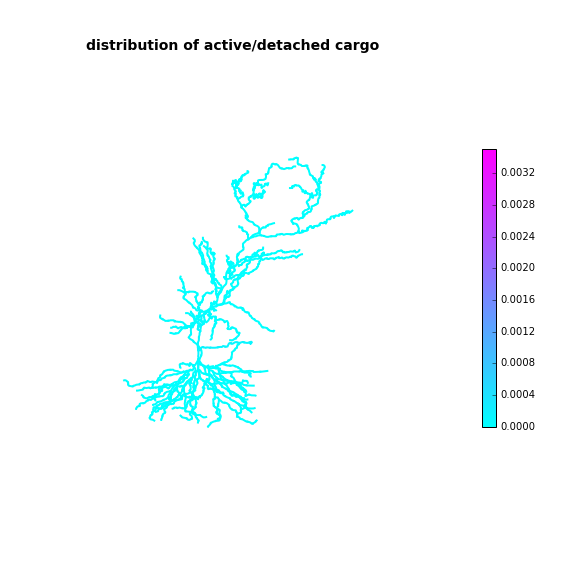
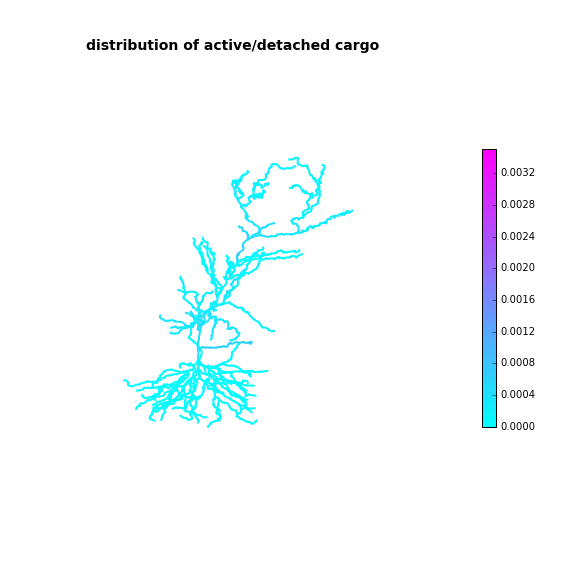
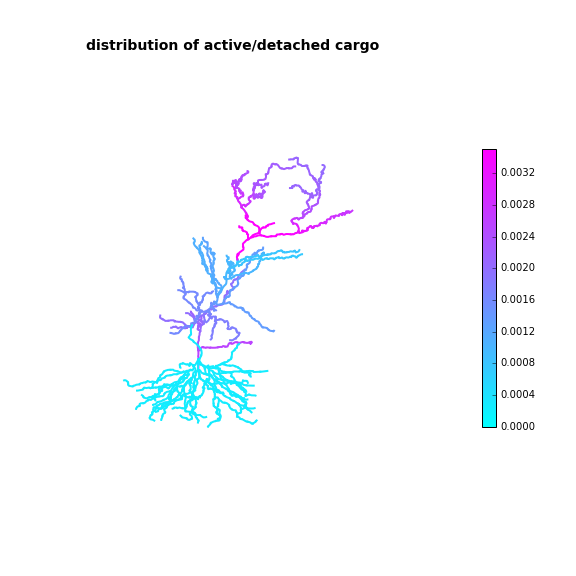
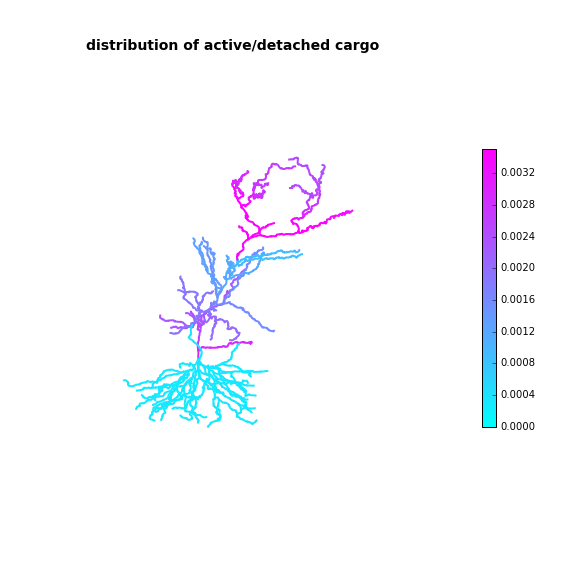
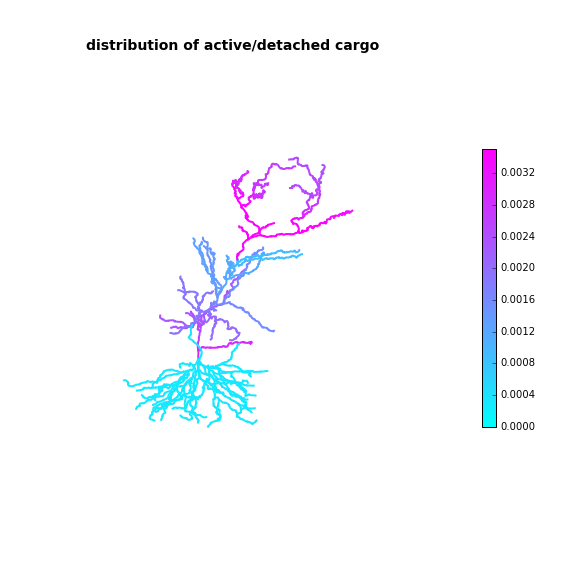
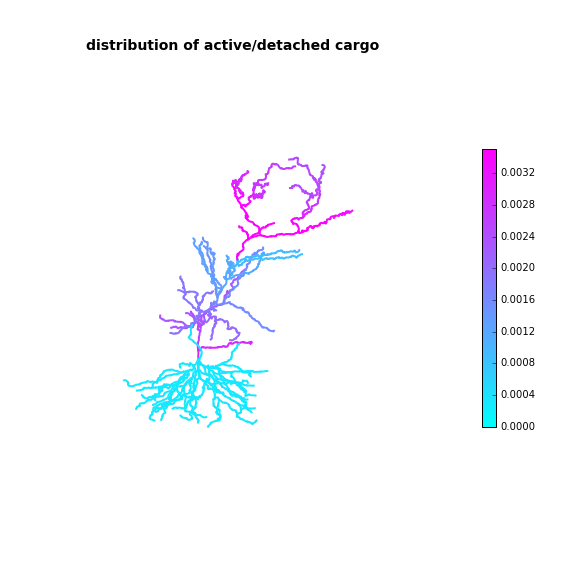
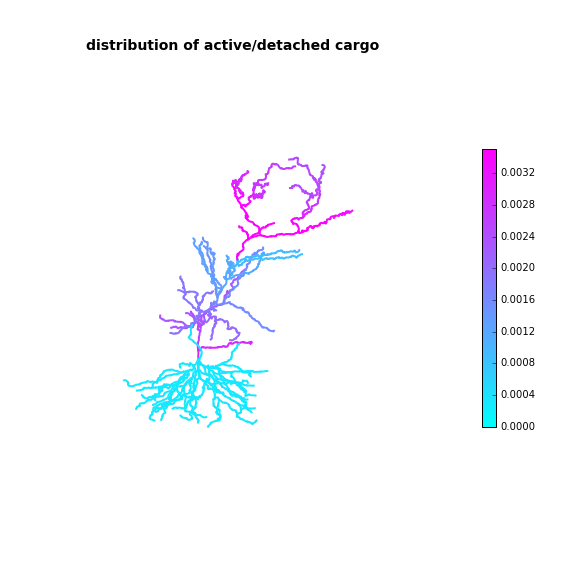

In [12]:
# Distal inputs alone
utarg = np.ones(len(seg_list))
utarg[260:393] *= 10
utarg[393:] *= 0.1 # no proximal trafficking
utarg /= np.sum(utarg)

# Run simulation
A = get_sys_matrix(utarg,F=0,Ctau=2e-4)
utrace = run_sim(A)

# snapshot of steady-state
# snap_ss('3a')

# animation
animate_sim()


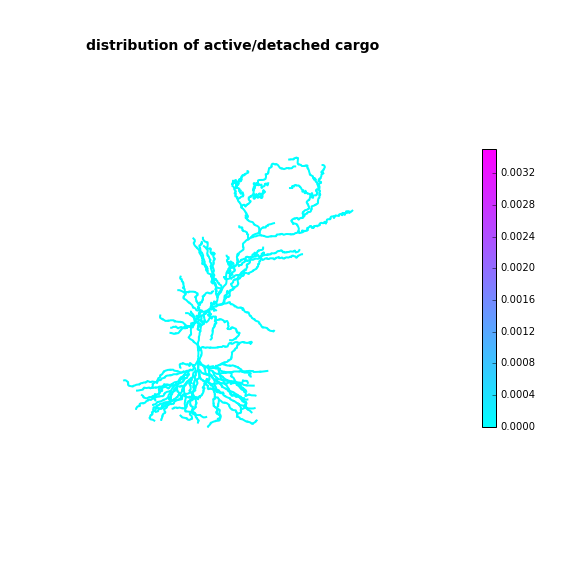
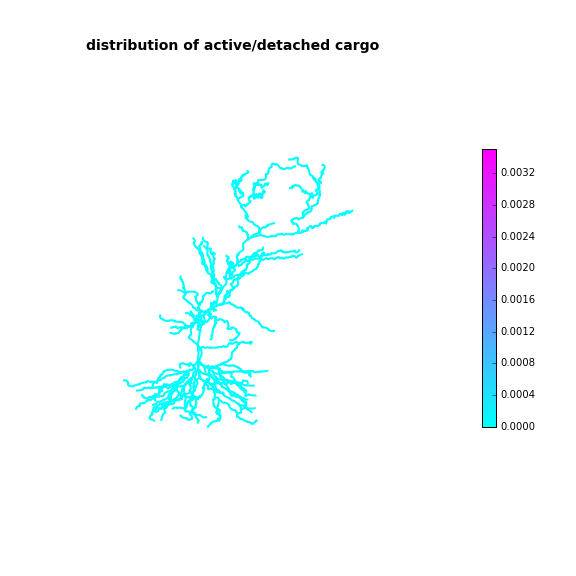
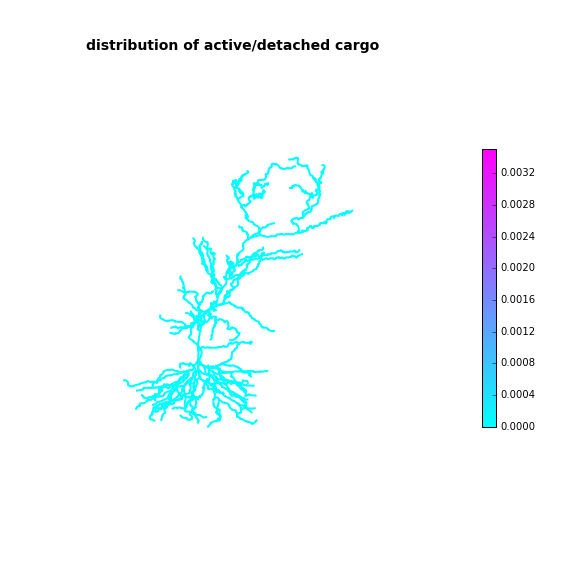
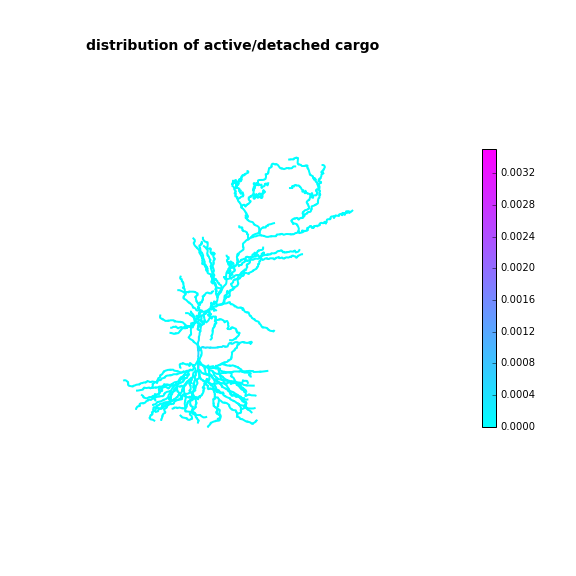
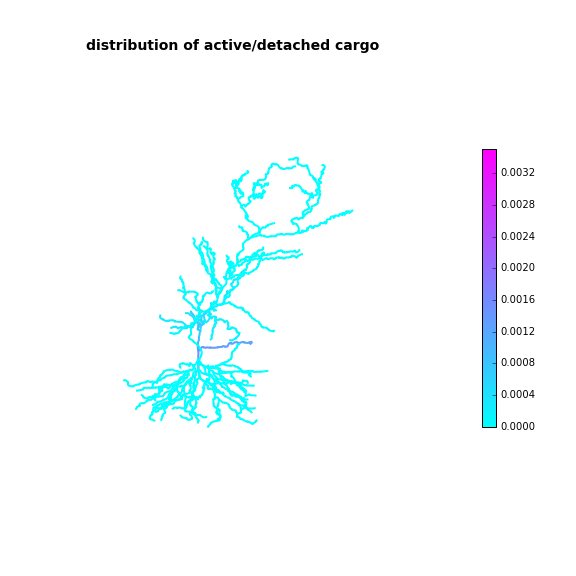
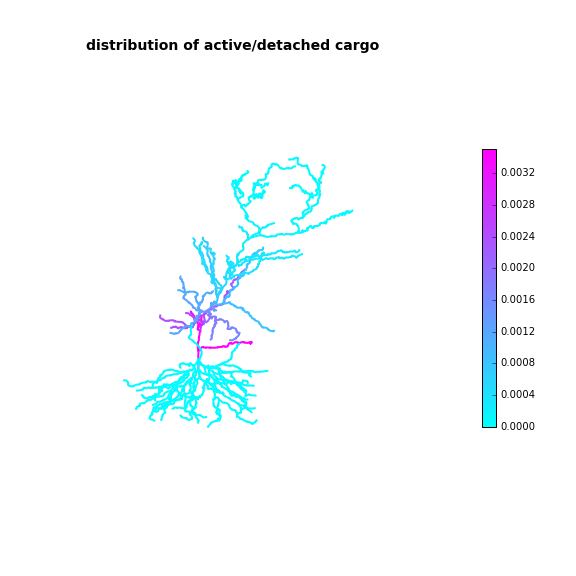
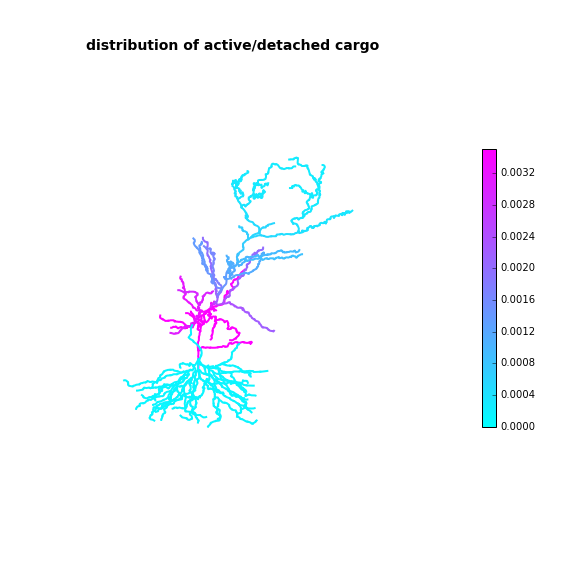
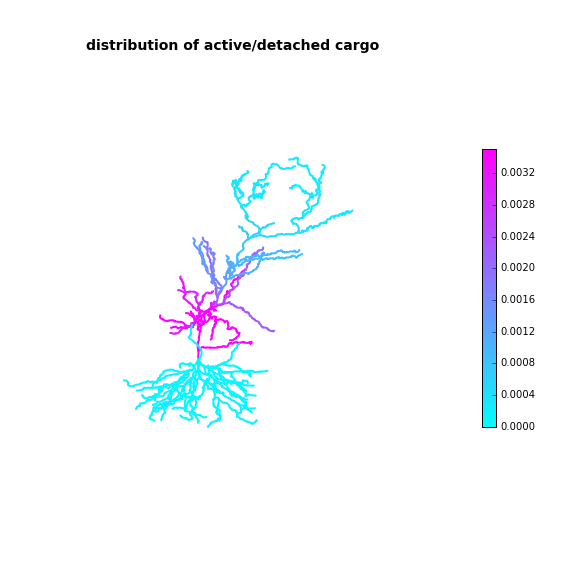
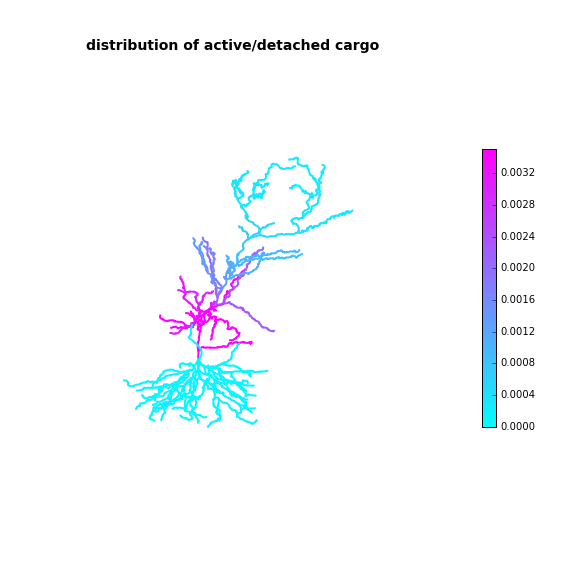
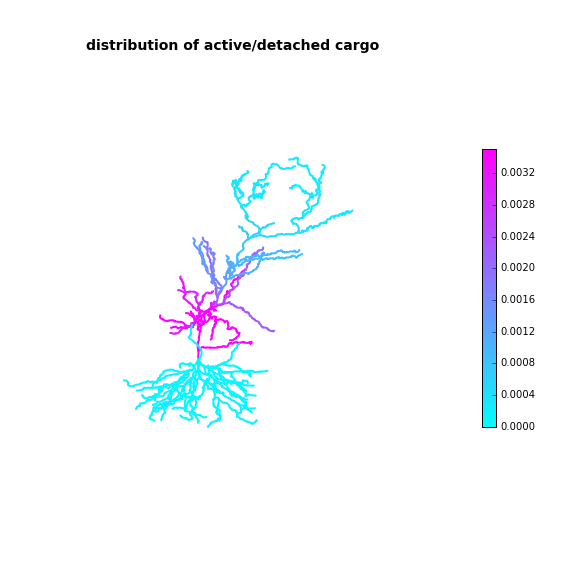
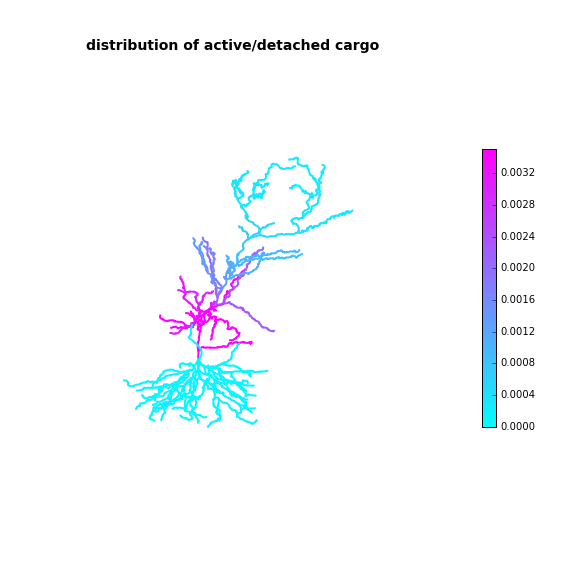

In [13]:
# Distal and Proximal together
utarg = np.ones(len(seg_list))
utarg[:393] *= 10
utarg[393:] *= 0.1 # no proximal trafficking
utarg /= np.sum(utarg)

# Run simulation
A = get_sys_matrix(utarg,F=0,Ctau=5e-4)
utrace = run_sim(A)

# snapshot of steady-state
# snap_ss('3b')

# animation
animate_sim()